In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
with open('/home/xzhou126/ssm/data/roi_timeseries_rsfMRI_HCP_model_selection', 'rb') as f:
    datas = pickle.load(f)
with open('/home/xzhou126/ssm/data/tags_rsfMRI_HCP_model_selection', 'rb') as f:
    tags = pickle.load(f)
# get data and tags for selected fold  
subject_id = np.unique(tags)
folds = []
for i in range(10):
    folds.append(np.arange(10*i, 10*(i+1), dtype=int))

In [5]:
K = 6
D_list = [2,3,4,5,6,7,8,9,10,15]
num_run = 4*90

In [ ]:
r_square = np.zeros((10, len(D_list), num_run))
r_square_cortex = np.zeros((10, len(D_list), num_run))
r_square_subcortex = np.zeros((10, len(D_list), num_run))

for fold in range(10):
    tags_train = list(np.concatenate([np.repeat(subject_id[l], 4) for l in range(100) if l not in folds[fold]]))
    datas_train = [datas[i] for i in range(400) if tags[i] in tags_train]

    for d in range(len(D_list)):
        with open('/home/xzhou126/ssm/model_selection_models/K%s_D%s_model-%s.pkl'%(K,D_list[d],fold+1), 'rb') as f:
            [model, q, elbos, q_z] = pickle.load(f)
    
        num_roi = model.N
        num_subject = len(np.unique(model.tags))
        pid = np.unique(model.tags)

        C = model.parent.emissions.Cs[0]

        for i in range(num_run):
            ys = datas_train[i]
            tag = tags_train[i]
            zs = q_z[i]
        
            residual = np.zeros((len(zs), num_roi))

            def one_step_predict(y_t, z_t):
                y_hat = C.dot(model.parent.dynamics.As[z_t]).dot(C.T).dot(y_t) + C.dot(model.parent.dynamics.bs[z_t]) 
                return y_hat
        
            for t in range(len(zs)):
                if t==0:
                    residual[t,:] = 0
                else:
                    residual[t,:] = ys[t,:] - one_step_predict(ys[t-1,:], zs[t-1])

            # R-square for given fold and D
            r_square[fold, d, i] = 1-np.linalg.norm(np.cov(residual.T))/np.linalg.norm(np.cov(ys.T))
            r_square_cortex[fold, d, i] = 1-np.linalg.norm(np.cov(residual[:,54:254].T))/np.linalg.norm(np.cov(ys[:,54:254].T))
            r_square_subcortex[fold, d, i] = 1-np.linalg.norm(np.cov(residual[:,0:54].T))/np.linalg.norm(np.cov(ys[:,0:54].T))

        print('fold %s'%(fold + 1), 'D %s'%(D_list[d]), 'finished')

In [16]:
RSS = np.mean(r_square, axis = 2)
mean_RS = np.mean(RSS, axis = 0)
lcb_RS = np.quantile(RSS, 0.05, axis = 0)
ucb_RS = np.quantile(RSS, 0.95, axis = 0)

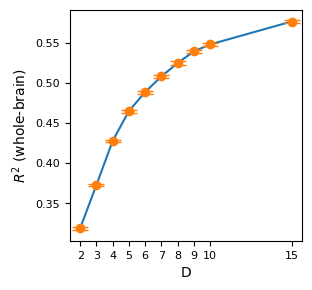

In [ ]:
x = D_list
y = mean_RS
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3))
plt.plot(x,y)
err_bar = np.array([mean_RS-lcb_RS, ucb_RS-mean_RS])
ax.errorbar(x, y, err_bar, fmt='o', markersize = 6, linewidth=2, capsize=6)
plt.xticks(x)
plt.xlabel("D", fontsize = 10)
plt.ylabel(r'$R^2$ (whole-brain)', fontsize = 10)
ax.tick_params(axis='y', labelsize=8)   
ax.tick_params(axis='x', labelsize=8)